# import modules

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
# light blue and orange
correct_color = "tab:blue"
incorrect_color = "tab:orange"
SEED = 314

# define functions

In [49]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

def calc_score(df):
    acc = calc_accuracy(df)
    rcl = recall_score(df['true_label'], df['predict_label'], average='macro')
    prc = precision_score(df['true_label'], df['predict_label'], average='macro')
    f1 = f1_score(df['true_label'], df['predict_label'], average='macro')
    size = len(df)
    return {"acc": acc, "rcl": rcl, "prc": prc, "f1": f1, "size": size}

def preprocess_df(raw_df:pd.DataFrame, true_label:pd.DataFrame)->pd.DataFrame:
    df = raw_df.copy()
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    min_max_func = lambda x: (x - x.min()) / (x.max() - x.min()) # min-max normalization
    convert_probability_func = lambda x: x / x.sum() # convert to binary
    processed_df = df.apply(min_max_func, axis=1).apply(convert_probability_func, axis=1)
    processed_df.columns = LABELS
    processed_df["predict_probability"] = processed_df.max(axis=1)
    processed_df["predict_label"] = processed_df.idxmax(axis=1)
    processed_df['true_label'] = true_label.map(lambda x: LABELS[x])
    return processed_df

def show_count(processed_df, title):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color])
    plt.title(f'{title}\nPredict Probability Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.ylim(0,400)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    # plt.savefig(f'assets/{title}-count.png')
    plt.show()

def show_count_stacked(processed_df, title, split_size=0.01):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df = df.loc[:,['incorrect', 'correct',]]
    correct_list = list()
    incorrect_list = list()
    split_num = int(1/split_size)
    for i in range(split_num,0,-1):
        i *= split_size
        correct_list.append((df.correct>i).sum())
        incorrect_list.append((df.incorrect>i).sum())
    correct_list.reverse()
    incorrect_list.reverse()
    plt.bar(np.arange(split_num)*split_size, incorrect_list, width=split_size, color=incorrect_color)
    plt.bar(np.arange(split_num)*split_size, correct_list, width=split_size, color=correct_color, bottom=incorrect_list)
    plt.title(f'{title}\nPredict Probability Stacked Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    # plt.savefig(f'assets/{title}-count-stacked.png')
    plt.show()

def show_dist(processed_df, title):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color])
    plt.title(f'{title}\nPredict Probability Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.ylim(0,400)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    split_size = 0.1
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df = df.loc[:,['incorrect', 'correct',]]
    correct_list = list()
    incorrect_list = list()
    split_num = int(1/split_size)
    for i in range(split_num,0,-1):
        i *= split_size
        correct_list.append((df.correct>i).sum())
        incorrect_list.append((df.incorrect>i).sum())
    correct_list.reverse()
    incorrect_list.reverse()
    plt.bar(np.arange(split_num)*split_size, incorrect_list, width=split_size, color=incorrect_color)
    plt.bar(np.arange(split_num)*split_size, correct_list, width=split_size, color=correct_color, bottom=incorrect_list)
    plt.title(f'{title}\nPredict Probability Stacked Count\nACC: {acc:.4f}')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    # plt.savefig(f'assets/{title}-count-stacked.png')
    plt.show()

def show_confusion_matrix(df, title):
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    cm = confusion_matrix(df['true_label'], df['predict_label'], labels=LABELS)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=LABELS, yticklabels=LABELS)
    plt.title(f'{title}\nConfusion Matrix\nACC: {calc_accuracy(df):.4f}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    # plt.savefig(f'assets/{title}-confusion-matrix.png')
    plt.show()

def calc_thredshold_df(df):
    delta = 0.01
    thresholds = [i*delta for i in range(int(1//delta+1))]
    acc_list = list()
    count_list = list()
    for threshold in thresholds:
        acc_list.append(calc_accuracy(df.loc[df.predict_probability>threshold]))
        count_list.append(len(df.loc[df.predict_probability>threshold]))
    threshold_df = pd.DataFrame({'threshold': thresholds, 'accuracy': acc_list, 'count': count_list})
    return threshold_df.set_index('threshold')

# load data

In [50]:
convbbt_layer3_raw_df = pd.read_csv('../cnn1d/predict.csv', index_col=0).drop(columns=["true"])
convbbt_layer5_raw_df = pd.read_csv('../convbbt/predict.csv', index_col=0).drop(columns=["true"])
convbbt_layer7_raw_df = pd.read_csv('../vit/predict.csv', index_col=0).drop(columns=["true"])
true_label = pd.read_csv('../convbbt/predict.csv', index_col=0)["true"]

# check data

## raw data head

In [51]:
convbbt_layer3_raw_df.head()

,0,1,2,3,4,5
0,-41.391300,-19.525230,-41.098103,-40.247326,8.594010,16.886126
1,-23.017810,-37.092327,32.698044,1.198529,-7.665591,-26.310192
2,-25.394966,-44.099842,-50.211735,-58.358400,23.554977,-7.026921
3,-3.719642,33.317510,-86.934020,-88.753174,-1.316395,-32.161095
4,-12.965935,-19.494660,-0.595499,12.329179,2.745328,-19.452412


In [52]:
convbbt_layer5_raw_df.head()

,0,1,2,3,4,5
0,2.667278,-6.223639,-10.455910,-7.705863,3.942457,5.992100
1,-3.501386,-5.147262,15.075128,7.256400,-0.475929,-2.861587
2,3.822823,-9.720933,-9.241361,-5.683146,6.891798,3.425873
3,3.279096,11.735168,-4.228587,-1.351361,-4.169562,-4.644408
4,-2.105618,-2.101908,0.199927,13.780579,-3.819936,-1.524870


In [53]:
convbbt_layer7_raw_df.head()

,0,1,2,3,4,5
0,3.011206,-5.817851,-5.217103,-7.638794,0.831200,9.454015
1,1.910253,-6.772700,15.421850,2.738583,-5.358047,-3.725187
2,-1.027743,-7.089542,-5.357136,-3.138410,12.560061,1.079521
3,-2.923320,15.512492,-7.420484,-7.753412,1.668159,-0.424469
4,1.624771,-4.469953,-0.402944,15.373968,-4.972460,-5.154066


In [54]:
convbbt_layer3_df = preprocess_df(convbbt_layer3_raw_df, true_label)
convbbt_layer5_df = preprocess_df(convbbt_layer5_raw_df, true_label)
convbbt_layer7_df = preprocess_df(convbbt_layer7_raw_df, true_label)

## processed data head

In [55]:
convbbt_layer3_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.000000,0.166199,0.002229,0.008695,0.379926,0.442952,0.442952,Walking,Walking
1,0.086685,0.000000,0.429837,0.235833,0.181239,0.066407,0.429837,Sitting,Sitting
2,0.174767,0.075597,0.043192,0.000000,0.434292,0.272152,0.434292,Upstairs,Upstairs
3,0.240921,0.345856,0.005154,0.000000,0.247730,0.160339,0.345856,Jogging,Jogging
4,0.082087,0.000000,0.237624,0.400129,0.279629,0.000531,0.400129,Standing,Standing


In [56]:
convbbt_layer5_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.257560,0.083064,0.000000,0.053973,0.282588,0.322815,0.322815,Walking,Walking
1,0.039920,0.000000,0.490490,0.300848,0.113302,0.055439,0.490490,Sitting,Sitting
2,0.283220,0.000000,0.010029,0.084436,0.347397,0.274919,0.347397,Upstairs,Upstairs
3,0.278147,0.574988,0.014597,0.115599,0.016669,0.000000,0.574988,Jogging,Jogging
4,0.062686,0.062821,0.146990,0.643581,0.000000,0.083921,0.643581,Standing,Standing


# Eval-Test split(with StratifiedKFold)

In [57]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
test_index, eval_index = skf.split(convbbt_layer3_df, true_label).__next__()

In [58]:
eval_index.__len__()

824

In [59]:
test_index.__len__()

7413

In [60]:
convbbt_layer3_eval_df, convbbt_layer3_test_df = convbbt_layer3_df.iloc[eval_index], convbbt_layer3_df.iloc[test_index]
convbbt_layer5_eval_df, convbbt_layer5_test_df = convbbt_layer5_df.iloc[eval_index], convbbt_layer5_df.iloc[test_index]
convbbt_layer7_eval_df, convbbt_layer7_test_df = convbbt_layer7_df.iloc[eval_index], convbbt_layer7_df.iloc[test_index]
true_eval_label, true_test_label = true_label.iloc[eval_index], true_label.iloc[test_index]
del convbbt_layer3_df, convbbt_layer5_df, convbbt_layer7_df

In [61]:
len(convbbt_layer3_eval_df), len(convbbt_layer3_test_df)

(824, 7413)

## count

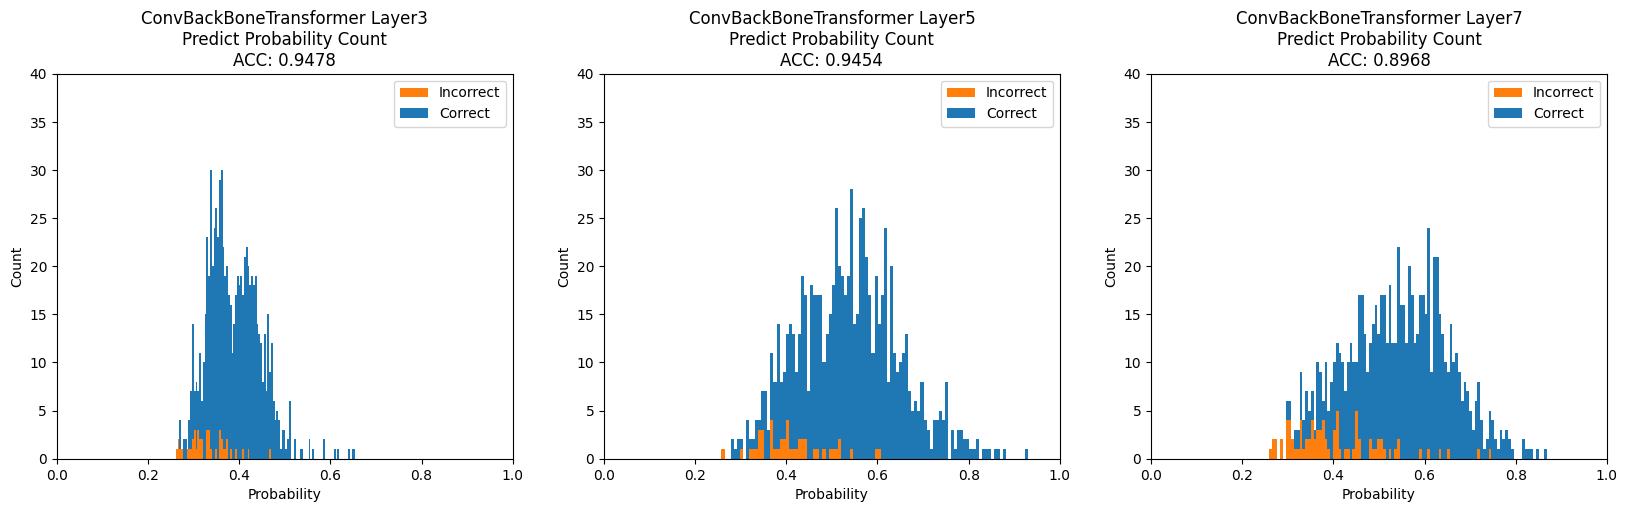

In [62]:
# 3枚描画空間を確保
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
x_limit = (0, 1)
y_limit = (0, 40)
x_label = 'Probability'
y_label = 'Count'
legend = ['Incorrect', 'Correct']

# 1枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer3'
df = convbbt_layer3_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[0])
axes[0].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[0].legend(legend)
# 2枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer5'
df = convbbt_layer5_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[1])
axes[1].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[1].legend(legend)
# 3枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer7'
df = convbbt_layer7_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[2])
axes[2].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[2].legend(legend)

plt.show()

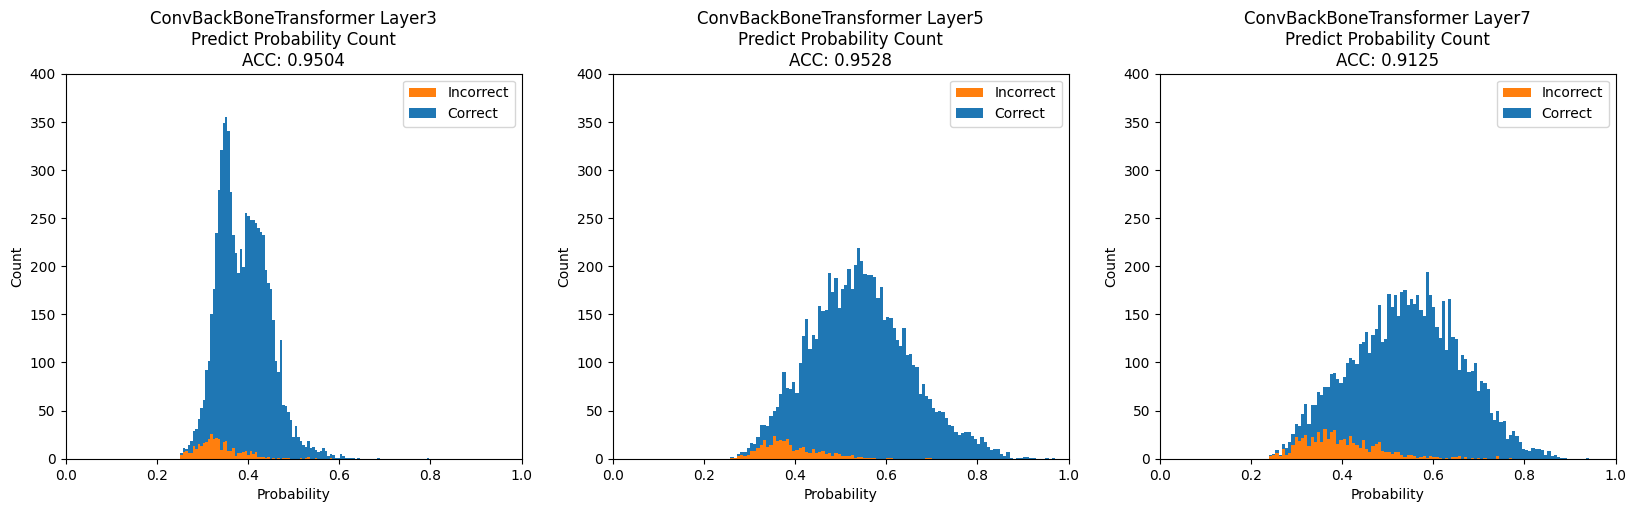

In [63]:
# 3枚描画空間を確保
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
x_limit = (0, 1)
y_limit = (0, 400)
x_label = 'Probability'
y_label = 'Count'
legend = ['Incorrect', 'Correct']

# 1枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer3'
df = convbbt_layer3_test_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[0])
axes[0].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[0].legend(legend)
# 2枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer5'
df = convbbt_layer5_test_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[1])
axes[1].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[1].legend(legend)
# 3枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer7'
df = convbbt_layer7_test_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[2])
axes[2].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[2].legend(legend)

plt.show()

## Stacked Count

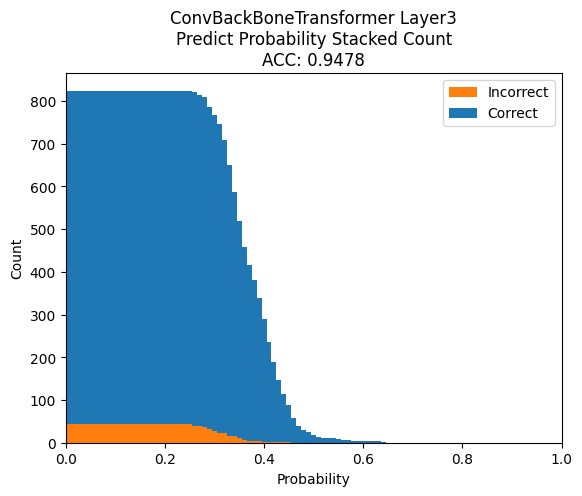

In [64]:
show_count_stacked(convbbt_layer3_eval_df, 'ConvBackBoneTransformer Layer3')

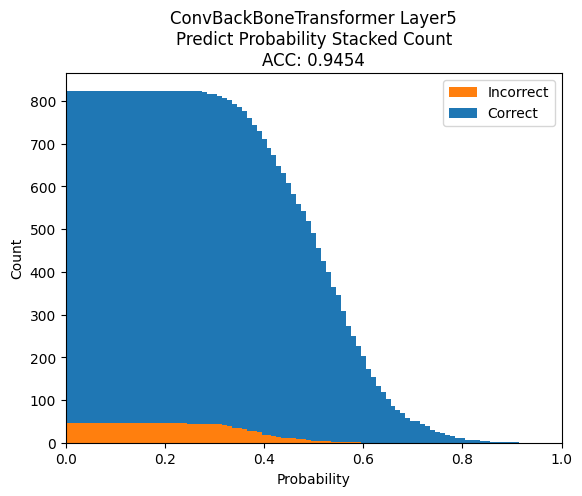

In [65]:
show_count_stacked(convbbt_layer5_eval_df, 'ConvBackBoneTransformer Layer5')

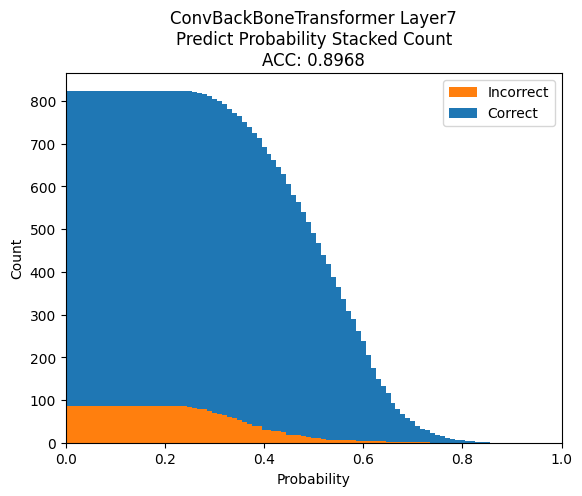

In [66]:
show_count_stacked(convbbt_layer7_eval_df, 'ConvBackBoneTransformer Layer7')

# Ensamble Model

## 4. Handle Ensamble

In [67]:
ensamble4_name = 'Handle-Ensamble'

In [68]:
calc_thredshold_df(convbbt_layer3_eval_df).dropna()

/tmp/ipykernel_149604/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.00,0.947816,824
0.01,0.947816,824
0.02,0.947816,824
0.03,0.947816,824
0.04,0.947816,824
...,...,...
0.61,1.000000,4
0.62,1.000000,3
0.63,1.000000,3


In [69]:
calc_thredshold_df(convbbt_layer5_eval_df).dropna()

/tmp/ipykernel_149604/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.00,0.945388,824
0.01,0.945388,824
0.02,0.945388,824
0.03,0.945388,824
0.04,0.945388,824
...,...,...
0.88,1.000000,1
0.89,1.000000,1
0.90,1.000000,1


In [70]:
calc_thredshold_df(convbbt_layer7_eval_df).dropna()

/tmp/ipykernel_149604/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.00,0.896845,824
0.01,0.896845,824
0.02,0.896845,824
0.03,0.896845,824
0.04,0.896845,824
...,...,...
0.82,1.000000,5
0.83,1.000000,3
0.84,1.000000,2


In [71]:
convbbt_layer3_995threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.995 else np.nan).idxmin()
convbbt_layer5_995threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.995 else np.nan).idxmin()
convbbt_layer7_995threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.995 else np.nan).idxmin()

convbbt_layer3_98threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()
convbbt_layer5_98threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()
convbbt_layer7_98threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()

convbbt_layer3_97threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()
convbbt_layer5_97threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()
convbbt_layer7_97threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()

convbbt_layer3_96threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()
convbbt_layer5_96threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()
convbbt_layer7_96threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()
convbbt_layer3_99threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.99 else np.nan).idxmin()
convbbt_layer5_99threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.99 else np.nan).idxmin()
convbbt_layer7_99threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.99 else np.nan).idxmin()

convbbt_layer3_98threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()
convbbt_layer5_98threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()
convbbt_layer7_98threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()

convbbt_layer3_97threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()
convbbt_layer5_97threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()
convbbt_layer7_97threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()

convbbt_layer3_96threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()
convbbt_layer5_96threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()
convbbt_layer7_96threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()

/tmp/ipykernel_149604/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_149604/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_149604/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_149604/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_149604/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_149604/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipyke

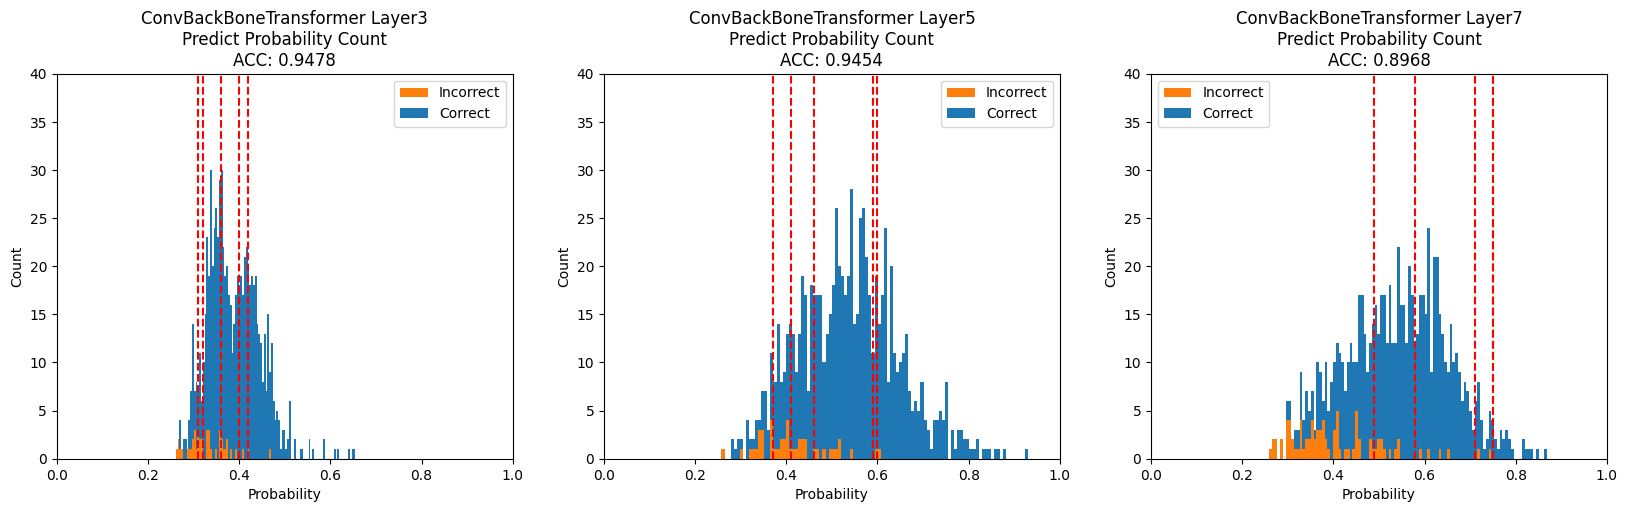

In [72]:
# 3枚描画空間を確保
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
x_limit = (0, 1)
y_limit = (0, 40)
x_label = 'Probability'
y_label = 'Count'
legend = ['Incorrect', 'Correct']

# 1枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer3'
df = convbbt_layer3_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[0])
# 閾値の描画
axes[0].axvline(convbbt_layer3_995threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_99threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_98threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_97threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_96threshold, color='r', linestyle='--')
axes[0].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[0].legend(legend)
# 2枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer5'
df = convbbt_layer5_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[1])
# 閾値の描画
axes[1].axvline(convbbt_layer5_995threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_99threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_98threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_97threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_96threshold, color='r', linestyle='--')
axes[1].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[1].legend(legend)
# 3枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer7'
df = convbbt_layer7_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[2])
# 閾値の描画
axes[2].axvline(convbbt_layer7_995threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_99threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_98threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_97threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_96threshold, color='r', linestyle='--')
axes[2].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[2].legend(legend)

plt.show()

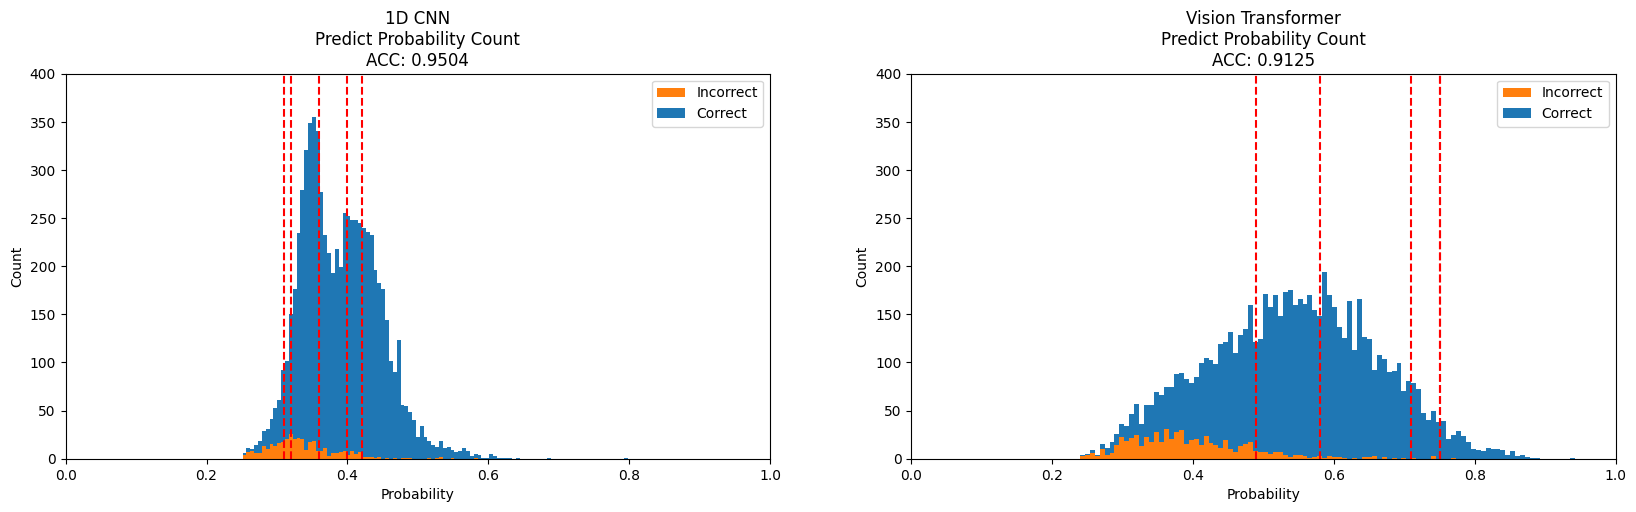

In [73]:
# 3枚描画空間を確保
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
x_limit = (0, 1)
y_limit = (0, 400)
x_label = 'Probability'
y_label = 'Count'
legend = ['Incorrect', 'Correct']

# 1枚目の描画空間に描画
title = '1D CNN'
df = convbbt_layer3_test_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[0])
# 閾値の描画（わかりやすく）
axes[0].axvline(convbbt_layer3_995threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_99threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_98threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_97threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_96threshold, color='r', linestyle='--')
axes[0].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[0].legend(legend)
# 2枚目の描画空間に描画
title = 'Vision Transformer'
df = convbbt_layer7_test_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[1])
# 閾値の描画
axes[1].axvline(convbbt_layer7_995threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer7_99threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer7_98threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer7_97threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer7_96threshold, color='r', linestyle='--')
axes[1].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[1].legend(legend)

plt.show()

In [74]:
print(f"Conv.BackBone Transformer Layer3 99.5% ACC: {calc_accuracy(convbbt_layer3_eval_df.loc[convbbt_layer3_eval_df.predict_probability>convbbt_layer3_995threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 99.5% ACC: {calc_accuracy(convbbt_layer5_eval_df.loc[convbbt_layer5_eval_df.predict_probability>convbbt_layer5_995threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 99.5% ACC: {calc_accuracy(convbbt_layer7_eval_df.loc[convbbt_layer7_eval_df.predict_probability>convbbt_layer7_995threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 99% ACC: {calc_accuracy(convbbt_layer3_eval_df.loc[convbbt_layer3_eval_df.predict_probability>convbbt_layer3_99threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 99% ACC: {calc_accuracy(convbbt_layer5_eval_df.loc[convbbt_layer5_eval_df.predict_probability>convbbt_layer5_99threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 99% ACC: {calc_accuracy(convbbt_layer7_eval_df.loc[convbbt_layer7_eval_df.predict_probability>convbbt_layer7_99threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 98% ACC: {calc_accuracy(convbbt_layer3_eval_df.loc[convbbt_layer3_eval_df.predict_probability>convbbt_layer3_98threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 98% ACC: {calc_accuracy(convbbt_layer5_eval_df.loc[convbbt_layer5_eval_df.predict_probability>convbbt_layer5_98threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 98% ACC: {calc_accuracy(convbbt_layer7_eval_df.loc[convbbt_layer7_eval_df.predict_probability>convbbt_layer7_98threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 97% ACC: {calc_accuracy(convbbt_layer3_eval_df.loc[convbbt_layer3_eval_df.predict_probability>convbbt_layer3_97threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 97% ACC: {calc_accuracy(convbbt_layer5_eval_df.loc[convbbt_layer5_eval_df.predict_probability>convbbt_layer5_97threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 97% ACC: {calc_accuracy(convbbt_layer7_eval_df.loc[convbbt_layer7_eval_df.predict_probability>convbbt_layer7_97threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 96% ACC: {calc_accuracy(convbbt_layer3_eval_df.loc[convbbt_layer3_eval_df.predict_probability>convbbt_layer3_96threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 96% ACC: {calc_accuracy(convbbt_layer5_eval_df.loc[convbbt_layer5_eval_df.predict_probability>convbbt_layer5_96threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 96% ACC: {calc_accuracy(convbbt_layer7_eval_df.loc[convbbt_layer7_eval_df.predict_probability>convbbt_layer7_96threshold,:])}")

Conv.BackBone Transformer Layer3 99.5% ACC: 0.9957446808510638
Conv.BackBone Transformer Layer5 99.5% ACC: 0.995575221238938
Conv.BackBone Transformer Layer7 99.5% ACC: 1.0

Conv.BackBone Transformer Layer3 99% ACC: 0.9911504424778761
Conv.BackBone Transformer Layer5 99% ACC: 0.9919678714859438
Conv.BackBone Transformer Layer7 99% ACC: 1.0

Conv.BackBone Transformer Layer3 98% ACC: 0.9807692307692307
Conv.BackBone Transformer Layer5 98% ACC: 0.9819376026272578
Conv.BackBone Transformer Layer7 98% ACC: 0.9805825242718447

Conv.BackBone Transformer Layer3 97% ACC: 0.9705488621151271
Conv.BackBone Transformer Layer5 97% ACC: 0.9732394366197183
Conv.BackBone Transformer Layer7 97% ACC: 0.9704251386321626

Conv.BackBone Transformer Layer3 96% ACC: 0.9635416666666666
Conv.BackBone Transformer Layer5 96% ACC: 0.9600515463917526
Conv.BackBone Transformer Layer7 96% ACC: 0.9607843137254902


In [75]:
print(f"Conv.BackBone Transformer Layer3 99.5% ACC: {calc_accuracy(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_995threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 99.5% ACC: {calc_accuracy(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_995threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 99.5% ACC: {calc_accuracy(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_995threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 99% ACC: {calc_accuracy(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_99threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 99% ACC: {calc_accuracy(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_99threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 99% ACC: {calc_accuracy(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_99threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 98% ACC: {calc_accuracy(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_98threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 98% ACC: {calc_accuracy(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_98threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 98% ACC: {calc_accuracy(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_98threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 97% ACC: {calc_accuracy(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_97threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 97% ACC: {calc_accuracy(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_97threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 97% ACC: {calc_accuracy(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_97threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 96% ACC: {calc_accuracy(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_96threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 96% ACC: {calc_accuracy(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_96threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 96% ACC: {calc_accuracy(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_96threshold,:])}")

Conv.BackBone Transformer Layer3 99.5% ACC: 0.9899405578417924
Conv.BackBone Transformer Layer5 99.5% ACC: 0.9980943306336351
Conv.BackBone Transformer Layer7 99.5% ACC: 0.996031746031746

Conv.BackBone Transformer Layer3 99% ACC: 0.9857605177993527
Conv.BackBone Transformer Layer5 99% ACC: 0.9982751185855973
Conv.BackBone Transformer Layer7 99% ACC: 0.996031746031746

Conv.BackBone Transformer Layer3 98% ACC: 0.9804744908671006
Conv.BackBone Transformer Layer5 98% ACC: 0.9899647887323944
Conv.BackBone Transformer Layer7 98% ACC: 0.9902574808629089

Conv.BackBone Transformer Layer3 97% ACC: 0.9679393762751385
Conv.BackBone Transformer Layer5 97% ACC: 0.9830097087378641
Conv.BackBone Transformer Layer7 97% ACC: 0.9826246933769419

Conv.BackBone Transformer Layer3 96% ACC: 0.9635180995475113
Conv.BackBone Transformer Layer5 96% ACC: 0.9727117680500285
Conv.BackBone Transformer Layer7 96% ACC: 0.9912587412587412


In [76]:
# importance in descending order

# convbbt_layer7
ensamble4_df = convbbt_layer7_test_df.copy()
ensamble4_df.loc[:,"method"] = "ConvBackBoneTransformer Layer7"

# 96% confidence-line
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_96threshold,:] = convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_96threshold,:]
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_96threshold,"method"] = "ConvBackBoneTransformer Layer3(96%-confidence-line)"
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_96threshold,:] = convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_96threshold,:]
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_96threshold,"method"] = "ConvBackBoneTransformer Layer5(96%-confidence-line)"
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_96threshold,:] = convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_96threshold,:]
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_96threshold,"method"] = "ConvBackBoneTransformer Layer7(96%-confidence-line)"

# 97% confidence-line
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_97threshold,:] = convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_97threshold,:]
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_97threshold,"method"] = "ConvBackBoneTransformer Layer3(97%-confidence-line)"
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_97threshold,:] = convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_97threshold,:]
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_97threshold,"method"] = "ConvBackBoneTransformer Layer5(97%-confidence-line)"
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_97threshold,:] = convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_97threshold,:]
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_97threshold,"method"] = "ConvBackBoneTransformer Layer7(97%-confidence-line)"

# 98% confidence-line
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_98threshold,:] = convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_98threshold,:]
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_98threshold,"method"] = "ConvBackBoneTransformer Layer3(98%-confidence-line)"
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_98threshold,:] = convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_98threshold,:]
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_98threshold,"method"] = "ConvBackBoneTransformer Layer5(98%-confidence-line)"
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_98threshold,:] = convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_98threshold,:]
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_98threshold,"method"] = "ConvBackBoneTransformer Layer7(98%-confidence-line)"

# 99% confidence-line
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_99threshold,:] = convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_99threshold,:]
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_99threshold,"method"] = "ConvBackBoneTransformer Layer3(99%-confidence-line)"
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_99threshold,:] = convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_99threshold,:]
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_99threshold,"method"] = "ConvBackBoneTransformer Layer5(99%-confidence-line)"
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_99threshold,:] = convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_99threshold,:]
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_99threshold,"method"] = "ConvBackBoneTransformer Layer7(99%-confidence-line)"

# 99.5% confidence-line
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_995threshold,:] = convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_995threshold,:]
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_995threshold,"method"] = "ConvBackBoneTransformer Layer3(99.5%-confidence-line)"
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_995threshold,:] = convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_995threshold,:]
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_995threshold,"method"] = "ConvBackBoneTransformer Layer5(99.5%-confidence-line)"
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_995threshold,:] = convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_995threshold,:]
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_995threshold,"method"] = "ConvBackBoneTransformer Layer7(99.5%-confidence-line)"


In [77]:
ensamble4_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label,method
0,0.000000,0.166199,0.002229,0.008695,0.379926,0.442952,0.442952,Walking,Walking,ConvBackBoneTransformer Layer3(99.5%-confidenc...
1,0.086685,0.000000,0.429837,0.235833,0.181239,0.066407,0.429837,Sitting,Sitting,ConvBackBoneTransformer Layer3(99.5%-confidenc...
2,0.174767,0.075597,0.043192,0.000000,0.434292,0.272152,0.434292,Upstairs,Upstairs,ConvBackBoneTransformer Layer3(99.5%-confidenc...
3,0.278147,0.574988,0.014597,0.115599,0.016669,0.000000,0.574988,Jogging,Jogging,ConvBackBoneTransformer Layer5(98%-confidence-...
4,0.062686,0.062821,0.146990,0.643581,0.000000,0.083921,0.643581,Standing,Standing,ConvBackBoneTransformer Layer5(99.5%-confidenc...


In [78]:
ensamble4_df["method"].value_counts()

ConvBackBoneTransformer Layer5(99.5%-confidence-line)    1991
ConvBackBoneTransformer Layer3(99.5%-confidence-line)    1766
ConvBackBoneTransformer Layer5(98%-confidence-line)      1030
ConvBackBoneTransformer Layer7(98%-confidence-line)       719
ConvBackBoneTransformer Layer3(99%-confidence-line)       699
ConvBackBoneTransformer Layer3(98%-confidence-line)       333
ConvBackBoneTransformer Layer7(99.5%-confidence-line)     252
ConvBackBoneTransformer Layer5(97%-confidence-line)       182
ConvBackBoneTransformer Layer5(99%-confidence-line)       138
ConvBackBoneTransformer Layer3(97%-confidence-line)       123
ConvBackBoneTransformer Layer7(97%-confidence-line)        85
ConvBackBoneTransformer Layer5(96%-confidence-line)        48
ConvBackBoneTransformer Layer7                             35
ConvBackBoneTransformer Layer3(96%-confidence-line)        12
Name: method, dtype: int64

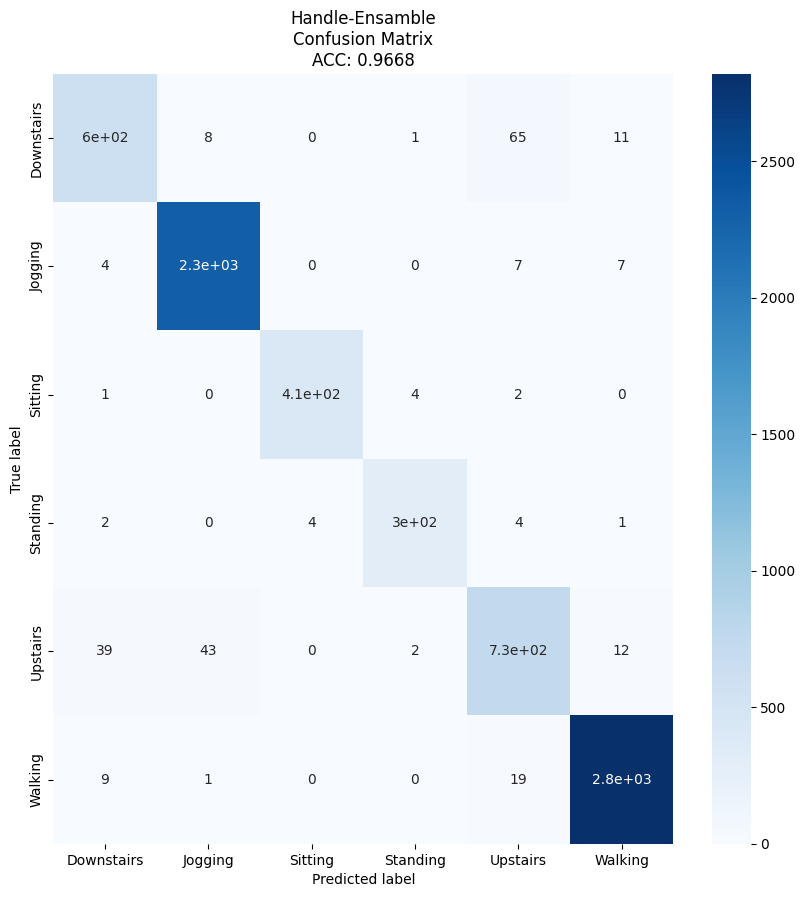

In [79]:
show_confusion_matrix(ensamble4_df, ensamble4_name)

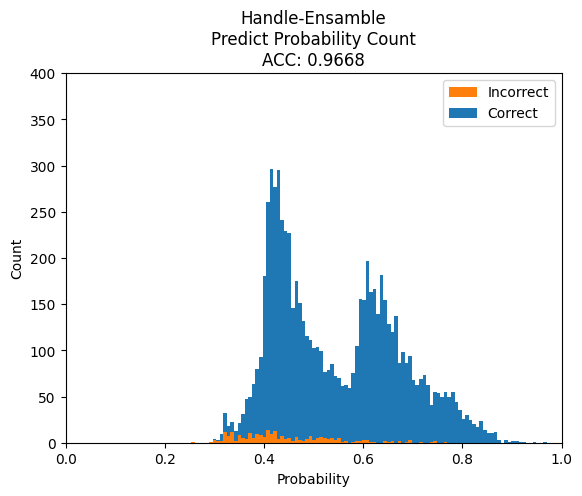

In [80]:
show_count(ensamble4_df, ensamble4_name)

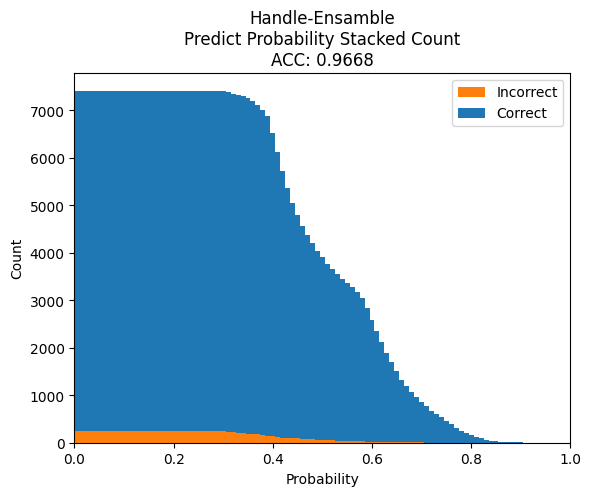

In [81]:
show_count_stacked(ensamble4_df, ensamble4_name)

In [82]:
print(f'Accuracy: {calc_accuracy(ensamble4_df):.4f}')
print(f'incorrect index num: {len(ensamble4_df.loc[ensamble4_df.true_label!=ensamble4_df.predict_label])}')
print("-"*50)
ensamble4_df.loc[ensamble4_df.predict_label!=ensamble4_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9668
incorrect index num: 246
--------------------------------------------------


Upstairs      97
Downstairs    55
Jogging       52
Walking       31
Standing       7
Sitting        4
Name: predict_label, dtype: int64

In [83]:
calc_thredshold_df(ensamble4_df).dropna()

/tmp/ipykernel_149604/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.00,0.966815,7413
0.01,0.966815,7413
0.02,0.966815,7413
0.03,0.966815,7413
0.04,0.966815,7413
...,...,...
0.93,1.000000,2
0.94,1.000000,2
0.95,1.000000,1


In [84]:
score_dict ={
            "all": calc_score(ensamble4_df),
            "99.5%": calc_score(ensamble4_df.loc[ensamble4_df.method.str.contains("99.5%"),:]),
            "99%": calc_score(ensamble4_df.loc[ensamble4_df.method.str.contains("99%"),:]),
            "98%": calc_score(ensamble4_df.loc[ensamble4_df.method.str.contains("98%"),:]),
            "97%": calc_score(ensamble4_df.loc[ensamble4_df.method.str.contains("97%"),:]),
            "96%": calc_score(ensamble4_df.loc[ensamble4_df.method.str.contains("96%"),:]),
            "rest": calc_score(ensamble4_df.loc[ensamble4_df.method=="ConvBackBoneTransformer Layer7",:]),
}
score_df = pd.DataFrame(score_dict).T
score_df

/home/nakagawa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nakagawa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,acc,rcl,prc,f1,size
all,0.966815,0.948175,0.955486,0.951737,7413.0
99.5%,0.993515,0.971896,0.987682,0.979444,4009.0
99%,0.974910,0.941417,0.943441,0.940418,837.0
98%,0.960134,0.933451,0.946729,0.939849,2082.0
97%,0.782051,0.740845,0.780123,0.742977,390.0
96%,0.783333,0.499487,0.587821,0.505128,60.0
rest,0.485714,0.424242,0.373077,0.378310,35.0


In [85]:
ensamble4_df.loc[ensamble4_df.method.str.contains("96%"),"true_label"].value_counts()

Downstairs    39
Upstairs      12
Walking        5
Jogging        3
Sitting        1
Name: true_label, dtype: int64

In [86]:
ensamble4_df.loc[ensamble4_df.method=="ConvBackBoneTransformer Layer7",:]

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label,method
176,0.323594,0.000000,0.113779,0.102986,0.233955,0.225685,0.323594,Downstairs,Downstairs,ConvBackBoneTransformer Layer7
348,0.222717,0.175193,0.000000,0.202542,0.334218,0.065329,0.334218,Upstairs,Walking,ConvBackBoneTransformer Layer7
382,0.075942,0.402684,0.099973,0.000167,0.421235,0.000000,0.421235,Upstairs,Sitting,ConvBackBoneTransformer Layer7
878,0.414199,0.143743,0.000000,0.022105,0.244134,0.175819,0.414199,Downstairs,Upstairs,ConvBackBoneTransformer Layer7
1866,0.203435,0.238589,0.129482,0.128377,0.300118,0.000000,0.300118,Upstairs,Downstairs,ConvBackBoneTransformer Layer7
2009,0.372641,0.199638,0.000000,0.113811,0.220702,0.093208,0.372641,Downstairs,Downstairs,ConvBackBoneTransformer Layer7
2106,0.298693,0.170420,0.076171,0.000000,0.085591,0.369126,0.369126,Walking,Downstairs,ConvBackBoneTransformer Layer7
2229,0.329531,0.000000,0.071363,0.133147,0.305811,0.160148,0.329531,Downstairs,Downstairs,ConvBackBoneTransformer Layer7
2366,0.405935,0.236367,0.000000,0.046374,0.168752,0.142572,0.405935,Downstairs,Downstairs,ConvBackBoneTransformer Layer7
2479,0.286307,0.040293,0.000000,0.027470,0.387210,0.258720,0.387210,Upstairs,Upstairs,ConvBackBoneTransformer Layer7


count1: 2187
count2: 2099
count3: 252


Text(0.5, 1.0, '99.5% Confidence-Line Venn Diagram\n    ACC: 0.9935\n    rest: 3404\n    ')

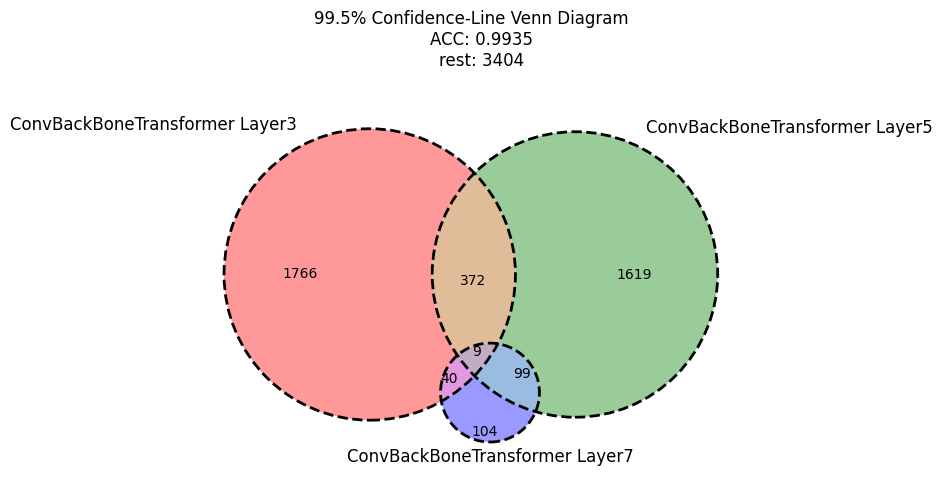

In [87]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_995threshold,:].index)
model2_set = set(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_995threshold,:].index)
model3_set = set(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_995threshold,:].index)

print(f"count1: {len(model1_set)}")
print(f"count2: {len(model2_set)}")
print(f"count3: {len(model3_set)}")

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''99.5% Confidence-Line Venn Diagram
    ACC: {calc_accuracy(ensamble4_df.loc[ensamble4_df.method.str.contains("99.5%"),:]):.4f}
    rest: {len(ensamble4_df)-len(model1_set|model2_set|model3_set)}
    ''')


/home/nakagawa/.local/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


Text(0.5, 1.0, '99% Confidence-Line Venn Diagram\n    ACC: 0.9749\n    rest: 6311\n    ')

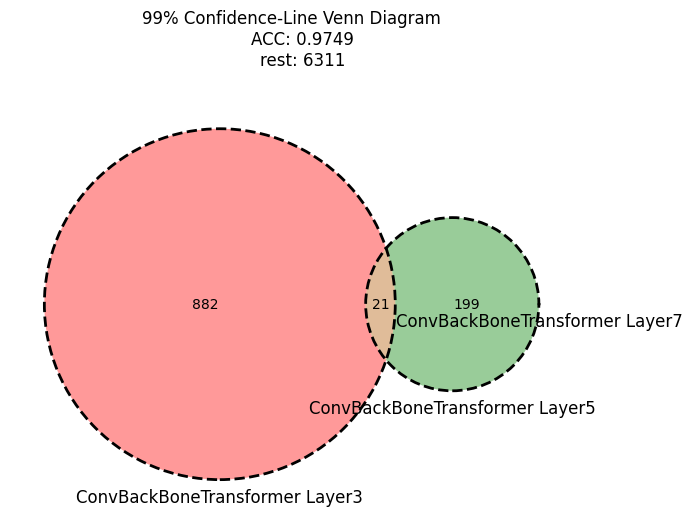

In [88]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[(convbbt_layer3_995threshold>convbbt_layer3_test_df.predict_probability)&(convbbt_layer3_test_df.predict_probability>convbbt_layer3_99threshold),:].index)
model2_set = set(convbbt_layer5_test_df.loc[(convbbt_layer5_995threshold>convbbt_layer5_test_df.predict_probability)&(convbbt_layer5_test_df.predict_probability>convbbt_layer5_99threshold),:].index)
model3_set = set(convbbt_layer7_test_df.loc[(convbbt_layer7_995threshold>convbbt_layer7_test_df.predict_probability)&(convbbt_layer7_test_df.predict_probability>convbbt_layer7_99threshold),:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''99% Confidence-Line Venn Diagram
    ACC: {calc_accuracy(ensamble4_df.loc[ensamble4_df.method.str.contains("99%"),:]):.4f}
    rest: {len(ensamble4_df)-len(model1_set|model2_set|model3_set)}
    ''')


Text(0.5, 1.0, '98% Confidence-Line Venn Diagram\n    ACC: 0.9601\n    rest: 2016\n    ')

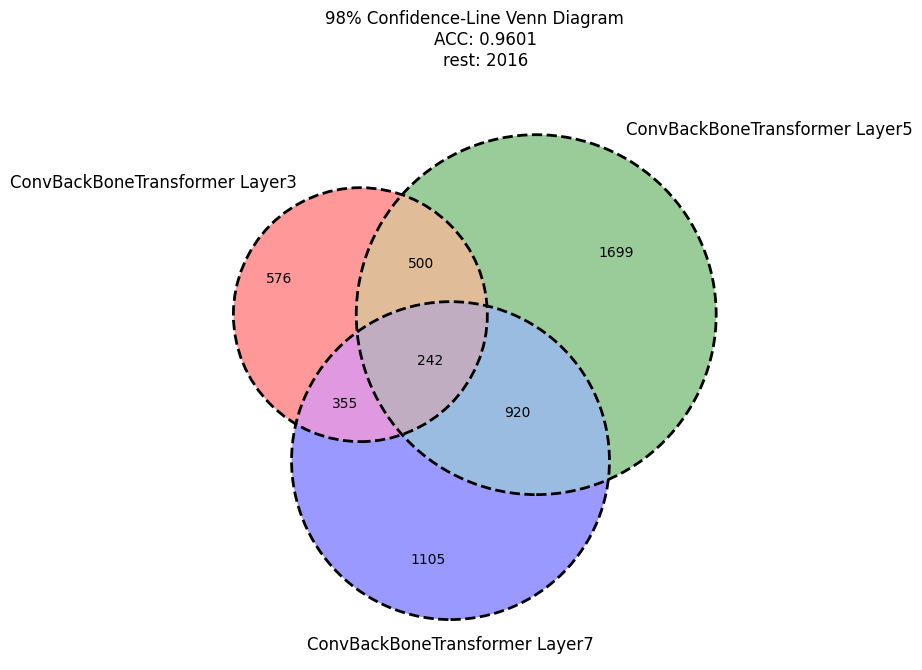

In [89]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[(convbbt_layer3_99threshold>convbbt_layer3_test_df.predict_probability)&(convbbt_layer3_test_df.predict_probability>convbbt_layer3_98threshold),:].index)
model2_set = set(convbbt_layer5_test_df.loc[(convbbt_layer5_99threshold>convbbt_layer5_test_df.predict_probability)&(convbbt_layer5_test_df.predict_probability>convbbt_layer5_98threshold),:].index)
model3_set = set(convbbt_layer7_test_df.loc[(convbbt_layer7_99threshold>convbbt_layer7_test_df.predict_probability)&(convbbt_layer7_test_df.predict_probability>convbbt_layer7_98threshold),:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''98% Confidence-Line Venn Diagram
    ACC: {calc_accuracy(ensamble4_df.loc[ensamble4_df.method.str.contains("98%"),:]):.4f}
    rest: {len(ensamble4_df)-len(model1_set|model2_set|model3_set)}
    ''')


Text(0.5, 1.0, '97% Confidence-Line Venn Diagram\n    ACC: 0.7821\n    rest: 3204\n    ')

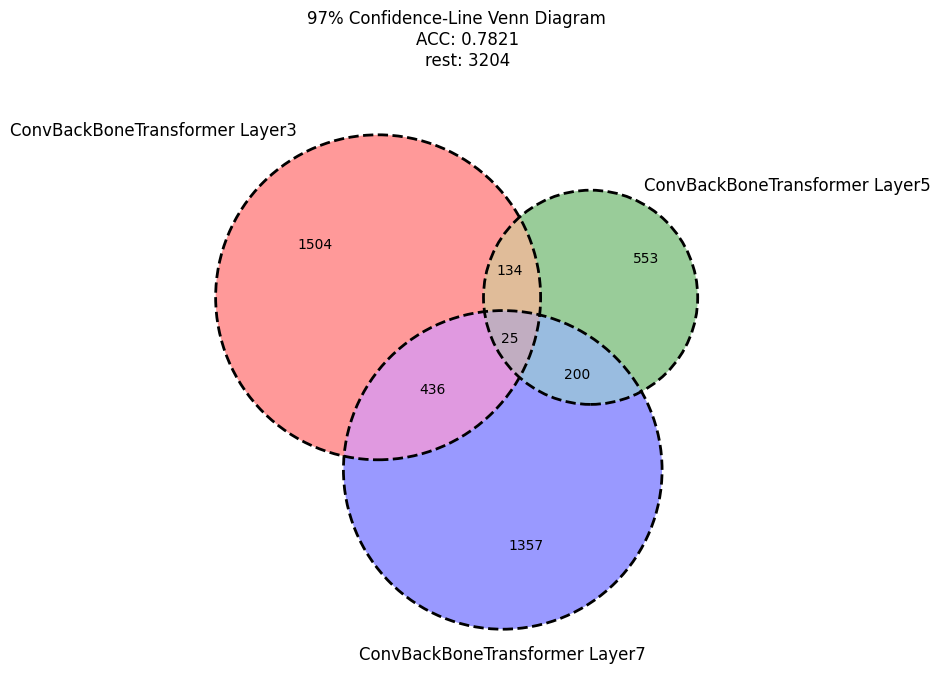

In [90]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[(convbbt_layer3_98threshold>convbbt_layer3_test_df.predict_probability)&(convbbt_layer3_test_df.predict_probability>convbbt_layer3_97threshold),:].index)
model2_set = set(convbbt_layer5_test_df.loc[(convbbt_layer5_98threshold>convbbt_layer5_test_df.predict_probability)&(convbbt_layer5_test_df.predict_probability>convbbt_layer5_97threshold),:].index)
model3_set = set(convbbt_layer7_test_df.loc[(convbbt_layer7_98threshold>convbbt_layer7_test_df.predict_probability)&(convbbt_layer7_test_df.predict_probability>convbbt_layer7_97threshold),:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''97% Confidence-Line Venn Diagram
    ACC: {calc_accuracy(ensamble4_df.loc[ensamble4_df.method.str.contains("97%"),:]):.4f}
    rest: {len(ensamble4_df)-len(model1_set|model2_set|model3_set)}
    ''')


Text(0.5, 1.0, '96% Confidence-Line Venn Diagram\n    ACC: 0.7833\n    rest: 6777\n    ')

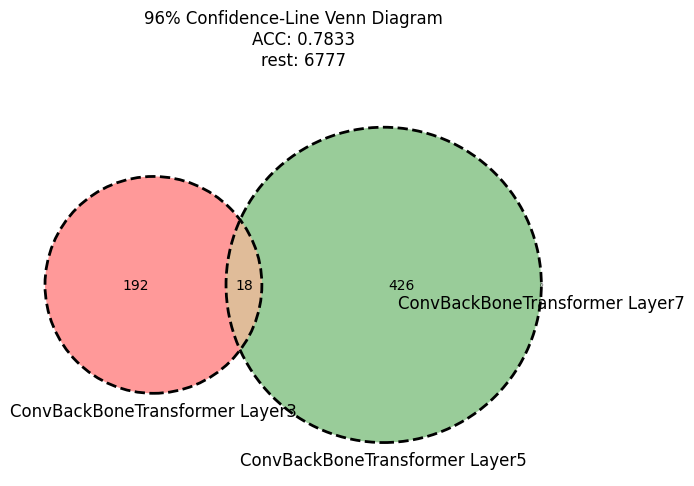

In [91]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[(convbbt_layer3_97threshold>convbbt_layer3_test_df.predict_probability)&(convbbt_layer3_test_df.predict_probability>convbbt_layer3_96threshold),:].index)
model2_set = set(convbbt_layer5_test_df.loc[(convbbt_layer5_97threshold>convbbt_layer5_test_df.predict_probability)&(convbbt_layer5_test_df.predict_probability>convbbt_layer5_96threshold),:].index)
model3_set = set(convbbt_layer7_test_df.loc[(convbbt_layer7_97threshold>convbbt_layer7_test_df.predict_probability)&(convbbt_layer7_test_df.predict_probability>convbbt_layer7_96threshold),:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''96% Confidence-Line Venn Diagram
    ACC: {calc_accuracy(ensamble4_df.loc[ensamble4_df.method.str.contains("96%"),:]):.4f}
    rest: {len(ensamble4_df)-len(model1_set|model2_set|model3_set)}
    ''')


Text(0.5, 1.0, 'Incorrect Venn Diagram\n    ')

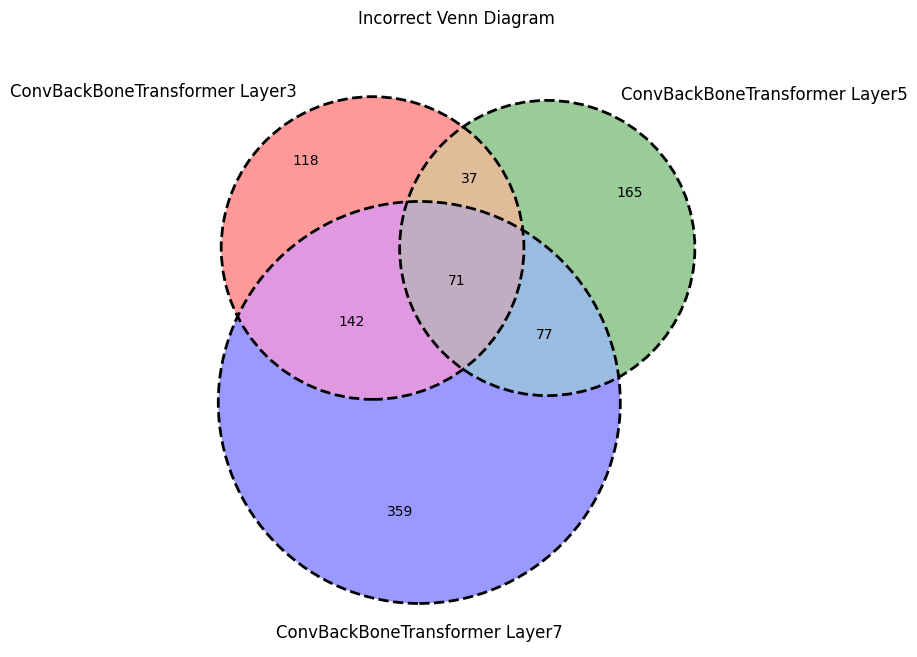

In [92]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_label!=convbbt_layer3_test_df.true_label,:].index)
model2_set = set(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_label!=convbbt_layer5_test_df.true_label,:].index)
model3_set = set(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_label!=convbbt_layer7_test_df.true_label,:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''Incorrect Venn Diagram
    ''')


Text(0.5, 1.0, 'ACC: 0.9668')

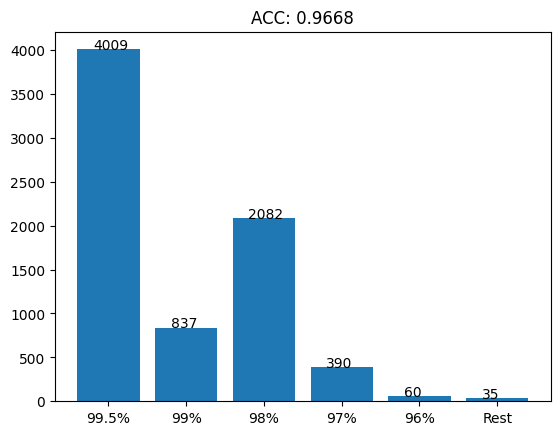

In [93]:
class_A_set = set(ensamble4_df.loc[ensamble4_df.method.str.contains("99.5%"),:].index)
class_B_set = set(ensamble4_df.loc[ensamble4_df.method.str.contains("99%"),:].index)
class_C_set = set(ensamble4_df.loc[ensamble4_df.method.str.contains("98%"),:].index)
class_D_set = set(ensamble4_df.loc[ensamble4_df.method.str.contains("97%"),:].index)
class_F_set = set(ensamble4_df.loc[ensamble4_df.method.str.contains("96%"),:].index)
class_G_set = set(ensamble4_df.loc[ensamble4_df.method=="ConvBackBoneTransformer Layer7",:].index)

class_name  = ["99.5%", "99%", "98%", "97%", "96%", "Rest"]
class_sets = [class_A_set, class_B_set, class_C_set, class_D_set, class_F_set, class_G_set]

plt.bar(class_name, [len(s) for s in class_sets])
plt.text(-0.2, len(class_A_set)+0.01, f'{len(class_A_set)}')
plt.text(0.8, len(class_B_set)+0.01, f'{len(class_B_set)}')
plt.text(1.8, len(class_C_set)+0.01, f'{len(class_C_set)}')
plt.text(2.8, len(class_D_set)+0.01, f'{len(class_D_set)}')
plt.text(3.8, len(class_F_set)+0.01, f'{len(class_F_set)}')
plt.text(4.8, len(class_G_set)+0.01, f'{len(class_G_set)}')
plt.title(f'''ACC: {calc_accuracy(ensamble4_df):.4f}''')